# **<font size="7">` Dependencies (must to run)`</font>**

___

In [1]:
import sys, os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
'main root'
main_path = os.path.abspath('../')
ds_root_path =  os.path.join(os.path.abspath('../..'),"ML_DataSet")
'pretrained model lib'
lib_main_path =  os.path.join(os.path.abspath('../..'),"trained")
sys.path.append(main_path)
from lib.utils.common import is_path_avaiable
from lib.visualization import Vis_PoseSampleTransform, Vis_PoseSampleTopdownAffine

'basic info'
print(" tensorflow version:",tf.__version__)
print(" numpy version:", np.__version__)
print(" Python version:", sys.version)
print(" sys.platform:", sys.platform)
print(" gpu available:", tf.config.list_physical_devices('GPU'))
print(" sys.path:", sys.path)
'dataset'
is_path_avaiable(ds_root_path)
"path of lib"
is_path_avaiable(main_path) 
"path to save model weights"
is_path_avaiable(lib_main_path) 


if  sys.platform == 'win32':
    'xla issue : https://www.qiniu.com/qfans/qnso-68614547#comments'
    #libdevice_path = "C:/Users/yista/anaconda3/envs/rtx_py38_tf2-10_cu118/Library/bin"
    #os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=C:/Users/yista/anaconda3/envs/rtx_py38_tf2-10_cu118/Library/bin"
    libdevice_path = "C:/Users/yista/anaconda3/envs/rtx_py38_tf2-10_cu118/Library/bin"
    is_path_avaiable(libdevice_path)
    os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir="+libdevice_path
    print(os.environ['XLA_FLAGS'])

2024-02-05 20:43:00.546482: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


key : BBoxesFormatTransform, value :<class 'lib.datasets.transforms.bboxes_format_transform.BBoxesFormatTransform'> >
key : ImageResize, value :<class 'lib.datasets.transforms.img_resize.ImageResize'> >
key : ImgPadResize, value :<class 'lib.datasets.transforms.img_resize.ImgPadResize'> >
key : Albumentations, value :<class 'lib.datasets.transforms.albumentations.Albumentations'> >
key : IdendityTest, value :<class 'lib.datasets.transforms.idendity_test.IdendityTest'> >
key : EnsureTensor, value :<class 'lib.datasets.transforms.ensure_to_tensor.EnsureTensor'> >
key : ImageNormalize, value :<class 'lib.datasets.transforms.img_norm.ImageNormalize'> >
key : RandomBBoxTransform, value :<class 'lib.datasets.transforms.random_bbox_transform.RandomBBoxTransform'> >
key : RandomFlip, value :<class 'lib.datasets.transforms.random_flip.RandomFlip'> >
key : RandomChannelShift, value :<class 'lib.datasets.transforms.random_channel_shift.RandomChannelShift'> >
key : RandomContrast, value :<class 'l

/Users/yistar/opt/anaconda3/envs/tf_metal/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2024-02-05 20:43:07.975455: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-05 20:43:07.975486: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical Plugga

### **<font size="6">`HyperParams`</font>**

In [2]:
'MODEL Type'
MODEL_TYPE = 'mvla_pose'
PROJECT_NAME = 'ViTpose'
'Golbal Settings'
USE_MIXED_PRECISION = True if sys.platform != 'darwin' else False
BATCH_SIZE = 32
PREFETCH_SIZE = 4
BATCH_NORM_EPSILON = 1e-5  #torch  :  bn_eps = 1e-5,  tensorflow : bn_eps = 1e-3
BATCH_NORM_MOMENTUM = 0.9  #torch  :  bn_moentum = 0.9,  tensorflow : bn_moentum = 0.99
CODEC_PARALLEL_ITERS = 32  #parallel_iterations
CV_TRANS_PARALLEL_ITERS = 32  #parallel_iterations
'Training'
TOTAL_EPOCHS = 200
WARMUP_EPOCHS = TOTAL_EPOCHS//10
LR = 1e-3


model_type = 'backbones'
probject_name = 'vit'
h5_file_name = 'ViT_b16_256x192_pretrained_weights.h5'
backbone_pretrained_weights_path =  os.path.join(lib_main_path, model_type, probject_name, h5_file_name)
is_path_avaiable(backbone_pretrained_weights_path)

## **<font size="6">`Mixed Precision (Optional)`</font>**

In [4]:
from tensorflow.keras import mixed_precision
if USE_MIXED_PRECISION :
    policy = mixed_precision.Policy('mixed_float16')
else:
    policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float32
Variable dtype: float32


## **<font size="6">`Data Paths`</font>**

In [5]:
'dataset root'
ds_main_path =  os.path.join(os.path.abspath('../..'),"ML_DataSet","COCO-WholeBody")
is_path_avaiable(ds_main_path)

'train/ val dataset path'
val_tfrec_kps_dir = os.path.join(ds_main_path, "tfrecords_kps_val")
'verify whether tfrecords_dir is exist'
is_path_avaiable(val_tfrec_kps_dir)

'train/ val dataset path'
train_tfrec_kps_dir = os.path.join(ds_main_path, "tfrecords_kps_train")
'verify whether tfrecords_dir is exist'
is_path_avaiable(train_tfrec_kps_dir)

'pretrained model lib'
lib_main_path =  os.path.join(os.path.abspath('../..'),"trained")
is_path_avaiable(lib_main_path)

successfully connect floder  : 
/Volumes/Extreme Pro/deep_learning/ML_DataSet/COCO-WholeBody

successfully connect floder  : 
/Volumes/Extreme Pro/deep_learning/ML_DataSet/COCO-WholeBody/tfrecords_kps_val

successfully connect floder  : 
/Volumes/Extreme Pro/deep_learning/ML_DataSet/COCO-WholeBody/tfrecords_kps_train

successfully connect floder  : 
/Volumes/Extreme Pro/deep_learning/trained



In [14]:
is_path_avaiable(ds_main_path)

successfully connect floder  : 
/Volumes/Extreme Pro/deep_learning/ML_DataSet/COCO-WholeBody



# **<font size="7">` 1. Build DataLoader`</font>**

## **<font size="6">`1-1. Train data pipeline `</font>**

register : <tfds_pipeline>  init ...................from internal libs


 All Modules of registry < tfds_pipeline >have been automatically imported from lib.datasets

--------------register : <tfds_pipeline>  Update Done-----from internal libs

successfully connect floder  : 
/Volumes/Extreme Pro/deep_learning/ML_DataSet/COCO-WholeBody/tfrecords_kps_train

samples_in_tfrec : 4269 @ <file_00-4269.tfrec>
samples_in_tfrec : 2899 @ <file_01-2899.tfrec>
samples_in_tfrec : 3523 @ <file_02-3523.tfrec>
samples_in_tfrec : 4124 @ <file_03-4124.tfrec>
samples_in_tfrec : 4701 @ <file_04-4701.tfrec>
samples_in_tfrec : 5047 @ <file_05-5047.tfrec>
samples_in_tfrec : 5178 @ <file_06-5178.tfrec>
samples_in_tfrec : 4789 @ <file_07-4789.tfrec>
samples_in_tfrec : 3984 @ <file_08-3984.tfrec>
samples_in_tfrec : 4326 @ <file_09-4326.tfrec>
samples_in_tfrec : 5605 @ <file_10-5605.tfrec>
samples_in_tfrec : 4492 @ <file_11-4492.tfrec>
samples_in_tfrec : 4104 @ <file_12-4104.tfrec>
samples_in_tfrec : 7010 @ <fil

register : <transforms>  init ...................from internal libs


 All Modules of registry < transforms >have been automatically imported from lib.datasets.transforms

--------------register : <transforms>  Update Done-----from internal libs



/Volumes/Extreme Pro/deep_learning/project_sample_V0.7/lib/datasets/tfds_builder.py:86: UserWarning: codec is None, you cannot gen targets used in traaining, but test_mode to review data is ok @pose_dataloader
  warnings.warn("codec is None, you cannot gen targets used in traaining, but test_mode to review data is ok @pose_dataloader")
2024-02-05 20:47:24.287862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'map/while/cond/cond/cond/cond_1/ones/map/while/cond/cond/strided_slice' with dtype int32 and shape [2]
	 [[{{node map/while/cond/cond/cond/cond_1/ones/map/while/cond/cond/strided_slice}}]]
2024-02-05 20:47:24.287939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARG


 ----------------pipeline_cfg  (< ith > --- key : value)  -------------------
< 1 >  --- RandomFlip : <lib.datasets.transforms.random_flip.RandomFlip object at 0x7f860247ddf0>
< 2 >  --- RandomHalfBody : <lib.datasets.transforms.random_half_body.RandomHalfBody object at 0x7f85e0d59490>
< 3 >  --- RandomBBoxTransform : <lib.datasets.transforms.random_bbox_transform.RandomBBoxTransform object at 0x7f85e0d597f0>
< 4 >  --- RandomKPSDropout : <lib.datasets.transforms.random_kps_dropout.RandomKPSDropout object at 0x7f85e0d59fa0>
< 5 >  --- TopdownAffine : <lib.datasets.transforms.topdown_transforms.TopdownAffine object at 0x7f85e0d9a5e0>
< 6 >  --- EnsureTensor : <lib.datasets.transforms.ensure_to_tensor.EnsureTensor object at 0x7f860247de50>
< 7 >  --- DataAdapter : <function dataloader.GenerateTargets.<locals>.<lambda> at 0x7f86024a13a0>
--------------------------------------------------------------------------------



2024-02-05 20:47:26.592465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_24' with dtype float
	 [[{{node Placeholder/_24}}]]
2024-02-05 20:47:26.592968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_24' with dtype float
	 [[{{node Placeholder/_24}}]]


==========Pack data type : Dict[str,Tensor] --Test Mode ============= 
image ----- TensorSpec(shape=(32, 256, 192, 3), dtype=tf.uint8, name=None)
bbox ----- TensorSpec(shape=(32, 4), dtype=tf.float32, name=None)
kps ----- TensorSpec(shape=(32, 17, 3), dtype=tf.float32, name=None)
image_size ----- TensorSpec(shape=(32, 2), dtype=tf.int32, name=None)
bbox_format ----- TensorSpec(shape=(32,), dtype=tf.string, name=None)
==========Pack data type : Dict[str,Tensor] --Test Mode ============= 
image ----- TensorSpec(shape=(32, 256, 192, 3), dtype=tf.uint8, name=None)
bbox ----- TensorSpec(shape=(32, 4), dtype=tf.float32, name=None)
kps ----- TensorSpec(shape=(32, 17, 3), dtype=tf.float32, name=None)
image_size ----- TensorSpec(shape=(32, 2), dtype=tf.int32, name=None)
bbox_format ----- TensorSpec(shape=(32,), dtype=tf.string, name=None)
tf.Tensor(
[[  0.         0.         0.      ]
 [  0.         0.         0.      ]
 [  0.         0.         0.      ]
 [  0.         0.         0.      ]
 [ 

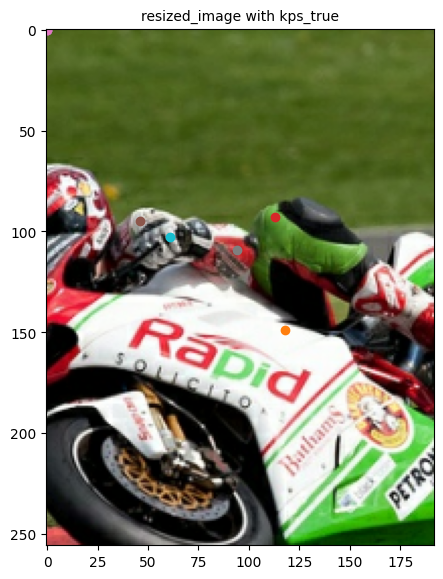

In [6]:
import copy
from lib.Registers import DATASETS
from lib.datasets.transforms import PackInputTensorTypeSpec

'#0 train / val dataset path'
# tfrec_train_dataset_cfg = dict(
#     type = 'BaseCocoStyleDataset_Parser', 
#     data_root = train_tfrec_kps_dir,
# )

tfrec_train_dataset_cfg = dict(
    type = 'Parser_CocoSinglePoseTFRec_CocoPoseStyle', 
    data_root = train_tfrec_kps_dir,
)


IdendityTest_cfg = dict(type='IdendityTest')

flip_cfg = dict(type='RandomFlip',prob=0.5)

halfbody_cfg = dict(
    type='RandomHalfBody',
    prob=0.5, 
    upper_prioritized_prob= 0.7,
    padding = 1.5,
    min_total_keypoints = 9, 
    min_upper_keypoints = 4,
    min_lower_keypoints = 4
)

bbox_cfg = dict(
    type='RandomBBoxTransform',  
    shift_factor = 0.16, 
    shift_prob = 0.5, 
    scale_factor = (0.75, 1.25), 
    scale_prob = 0.5 ,
)

contrast_cfg = dict(type = 'RandomContrast',
                value_range =(0,255), 
                factor =(0.3, 0.8),
                prob = 0.5,
                test_mode=False
)

hsv_cfg = dict(type='RandomHSVAug',  
            hue_prob = 0.5,
            saturation_prob = 0.5,
            brightness_prob = 0.5,
            hue_delta = 0.3, 
            saturation_factor = (0.5,2.0),
            brightness_delta = 0.4
)

blur_cfg = dict(type='RandomGaussianBlur', 
                kernel_size_xy=(5,5),
                factor=3.0,
                prob =0.5,
                test_mode=True
)
kpsdrop_cfg = dict(type='RandomKPSDropout',   
                base_mask_ratio = 0.05,
                mask_scale_factor = (0.8, 1.2),
                min_bbox_area = 64.*64.,
                prob=0.5, 
                drop_joints_indices=[5,6,7,8,11,12],
                random_mask_color=False, 
                test_mode =False
)

affine_cfg = dict(
    type='TopdownAffine',
    is_train = True, 
    test_mode = False,   
    do_clip = True,      
    keep_bbox_aspect_prob = 0.5,
    rotate_prob = 0.5,
    shear_prob = 0.,
    MaxRot_deg=30., 
    MaxShear_deg=0.
)


train_dataloader_cfg =  dict(
    type = 'dataloader',
    batch_size = BATCH_SIZE,
    prefetch_size = PREFETCH_SIZE,
    shuffle  =  True,
    tfrec_datasets_list = [tfrec_train_dataset_cfg],
    augmenters = [flip_cfg, halfbody_cfg, bbox_cfg, kpsdrop_cfg, affine_cfg],
    codec = None,
    ensure_to_tensor = True,
    parallel_iterations = CV_TRANS_PARALLEL_ITERS
)


train_tfds_builder = DATASETS.build(copy.deepcopy(train_dataloader_cfg))
batch_train_dataset = train_tfds_builder.GenerateTargets(
    test_mode=False, 
    unpack_x_y_sample_weight= False, 
    ds_weights =None)

train_tfds_builder.get_pipeline_cfg() 


batch_id = 9
for data in batch_train_dataset.take(1):
    TensorSpec = PackInputTensorTypeSpec(data,{})
    PackInputTensorTypeSpec(data,{}, show_log=True)
    #print(data.keys())
    #print( data['bbox_format'])

    #box_src_format, _ = tf.unique( tf.reshape( data['bbox_format'],(-1)) )
    reszied_images = data['image']
    bboxes = data['bbox']
    kps_true = data['kps']
    print(kps_true[batch_id])
    print(f"img_size : {reszied_images[batch_id].shape}")
    #print(src_kps)
    plt.figure(figsize=(5,10))
    image = reszied_images[batch_id]
    image = tf.cast(image, dtype=tf.uint8)
    plt.title('resized_image with kps_true', fontsize= 10)
    for i in range(0,kps_true.shape[1]):
        kps_x = int((kps_true[batch_id,i,0]))
        kps_y = int((kps_true[batch_id,i,1]))
        plt.scatter(kps_x,kps_y)
    plt.imshow(image.numpy())


# batch_id = 9
# for data in batch_train_dataset.take(1):
#     print(data.keys())
#     print( data['bbox_format'])
#     print( data['meta_info'].keys())
#     #box_src_format, _ = tf.unique( tf.reshape( data['bbox_format'],(-1)) )
 
#     reszied_images = data['image']
#     bboxes = data['bbox']
#     kps_true = data['kps']
#     print(kps_true[batch_id])

#     src_images = data['meta_info']['src_image']
#     src_kps = tf.reshape( data['meta_info']['src_keypoints'],[-1,17,3])
#     src_bboxes = data['meta_info']['src_bbox']

#     #print(src_kps)
#     plt.figure(figsize=(10,15))
#     'crop image' 
#     plt.subplot(1,2,1)
#     ax = plt.gca()
#     src_image = src_images[batch_id,...]
#     src_bbox = src_bboxes[batch_id,:]
#     src_image = tf.cast(src_image, dtype=tf.uint8)
#     plt.title('src_image with kps_true',fontsize= 10)
#     for i in range(0,src_kps.shape[1]):
#         kps_x = int((src_kps[batch_id,i,0]))
#         kps_y = int((src_kps[batch_id,i,1]))
#         plt.scatter(kps_x,kps_y)
#     x1, y1, w, h = src_bbox
#     patch = plt.Rectangle([x1, y1], w, h, fill=False, edgecolor=[0, 0, 1], linewidth=2)
#     ax.add_patch(patch)
#     plt.imshow(src_image.numpy())

#     plt.subplot(1,2,2)
#     image = reszied_images[batch_id]
#     image = tf.cast(image, dtype=tf.uint8)
#     plt.title('resized_image with kps_true', fontsize= 10)
#     for i in range(0,kps_true.shape[1]):
#         kps_x = int((kps_true[batch_id,i,0]))
#         kps_y = int((kps_true[batch_id,i,1]))
#         plt.scatter(kps_x,kps_y)
#     plt.imshow(image.numpy())

## **<font size="6">`1-2. Val data pipeline `</font>**

successfully connect floder  : 
/Volumes/Extreme Pro/deep_learning/ML_DataSet/COCO-WholeBody/tfrecords_kps_val

samples_in_tfrec : 1880 @ <file_00-1880.tfrec>
samples_in_tfrec : 2425 @ <file_01-2425.tfrec>
samples_in_tfrec : 1342 @ <file_02-1342.tfrec>
num_TotalSamples: 5647
successfully connect floder  : 
/Volumes/Extreme Pro/deep_learning/ML_DataSet/COCO-WholeBody/tfrecords_kps_val


 ----------------pipeline_cfg  (< ith > --- key : value)  -------------------
< 1 >  --- TopdownAffine : <lib.datasets.transforms.topdown_transforms.TopdownAffine object at 0x7f85f16b69a0>
< 2 >  --- EnsureTensor : <lib.datasets.transforms.ensure_to_tensor.EnsureTensor object at 0x7f8620b28580>
< 3 >  --- DataAdapter : <function dataloader.GenerateTargets.<locals>.<lambda> at 0x7f863199fb80>
--------------------------------------------------------------------------------



2024-02-05 20:48:02.637416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_17' with dtype float
	 [[{{node Placeholder/_17}}]]
2024-02-05 20:48:02.637784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_15' with dtype float and shape [2]
	 [[{{node Placeholder/_15}}]]


==========Pack data type : Dict[str,Tensor] --Test Mode ============= 
image ----- TensorSpec(shape=(32, 256, 192, 3), dtype=tf.uint8, name=None)
bbox ----- TensorSpec(shape=(32, 4), dtype=tf.float32, name=None)
kps ----- TensorSpec(shape=(32, 17, 3), dtype=tf.float32, name=None)
image_size ----- TensorSpec(shape=(32, 2), dtype=tf.int32, name=None)
bbox_format ----- TensorSpec(shape=(32,), dtype=tf.string, name=None)
img_size : (256, 192, 3)
tf.Tensor(
[[102.88547   30.399471   1.      ]
 [106.87492   24.40746    1.      ]
 [  0.         0.         0.      ]
 [115.85118   26.404797   1.      ]
 [  0.         0.         0.      ]
 [100.89075   66.35153    1.      ]
 [153.75096   53.36884    1.      ]
 [ 82.9382    99.30759    1.      ]
 [184.66924  104.300934   1.      ]
 [ 47.033142 114.28763    1.      ]
 [  0.         0.         0.      ]
 [116.84856  143.24901    1.      ]
 [154.74834  142.25034    1.      ]
 [103.88283  181.19841    1.      ]
 [  0.         0.         0.      ]
 [ 

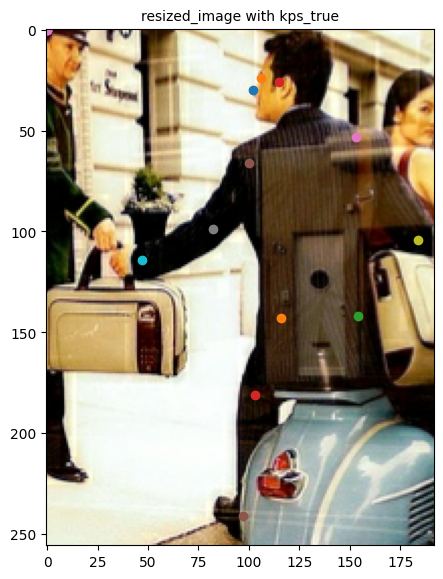

In [7]:
# tfrec_val_dataset_cfg = dict(
#     type = 'BaseCocoStyleDataset_Parser', 
#     data_root = val_tfrec_kps_dir,
# )
tfrec_val_dataset_cfg = dict(
    type = 'Parser_CocoSinglePoseTFRec_CocoPoseStyle', 
    data_root = val_tfrec_kps_dir,
)
val_affine_cfg = dict(
    type='TopdownAffine',
    is_train = False, 
    test_mode = False,   
    do_clip = True,      
    keep_bbox_aspect_prob = 1.,
    rotate_prob = 0.,
    shear_prob = 0.,
    MaxRot_deg=0., 
    MaxShear_deg=0.
)

val_dataloader_cfg =  dict(
    type = 'dataloader',
    batch_size = BATCH_SIZE,
    prefetch_size = PREFETCH_SIZE,
    shuffle  =  False,
    tfrec_datasets_list = [tfrec_val_dataset_cfg],
    augmenters = [val_affine_cfg],
    codec = None,
    ensure_to_tensor = True
)

val_tfds_builder = DATASETS.build(
    copy.deepcopy(val_dataloader_cfg)
)
batch_val_dataset = val_tfds_builder.GenerateTargets(
    test_mode=False,
    unpack_x_y_sample_weight= False, 
    ds_weights =None)
val_tfds_builder.get_pipeline_cfg() 
for data in batch_val_dataset.take(1):
    TensorSpec = PackInputTensorTypeSpec(data,{})
    print(f"img_size : {reszied_images[batch_id].shape}")
    #print(data.keys())
    #print( data['bbox_format'])
    #box_src_format, _ = tf.unique( tf.reshape( data['bbox_format'],(-1)) )
    reszied_images = data['image']
    bboxes = data['bbox']
    kps_true = data['kps']
    print(kps_true[batch_id])
    print(f"img_size : {reszied_images[batch_id].shape}")
    #print(src_kps)
    plt.figure(figsize=(5,10))
    image = reszied_images[batch_id]
    image = tf.cast(image, dtype=tf.uint8)
    plt.title('resized_image with kps_true', fontsize= 10)
    for i in range(0,kps_true.shape[1]):
        kps_x = int((kps_true[batch_id,i,0]))
        kps_y = int((kps_true[batch_id,i,1]))
        plt.scatter(kps_x,kps_y)
    plt.imshow(image.numpy())

# **<font size="7">` 2. Build Model`</font>**

In [6]:
"path of ViT backbone' s feature vector  "
model_type = 'backbones'
probject_name = 'vit'
h5_file_name = 'ViT_b16_256x192_pretrained_weights.h5'
pretrained_weights_path =  os.path.join(lib_main_path, model_type, probject_name, h5_file_name)
is_path_avaiable(pretrained_weights_path)

successfully connect floder  : 
h:\deep_learning\trained\backbones\vit\ViT_b16_256x192_pretrained_weights.h5



In [7]:
from lib.models.builder import build_backbone
from lib.models.backbones.vit import ViT

c:\Users\yista\anaconda3\envs\rtx_py38_tf2-10_cu118\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


key : RelativePositionalEmbedding, value :<class 'lib.layers.transformers.rel_pos_embs.RelativePositionalEmbedding'> >
key : AddRelativePositionBiasT5, value :<class 'lib.layers.transformers.rel_pos_embs.AddRelativePositionBiasT5'> >
key : RotaryPositionEmbedding, value :<class 'lib.layers.transformers.rope.RotaryPositionEmbedding'> >
key : GatedAttentionUnit, value :<class 'lib.layers.transformers.gau.GatedAttentionUnit'> >
key : ImgNormalization, value :<class 'lib.layers.pre_processors.img_norm.ImgNormalization'> >
key : ViT, value :<class 'lib.models.backbones.vit.ViT'> >
key : ResidualStepsBlock, value :<class 'lib.models.modules.rsb.ResidualStepsBlock'> >
key : CSPNeXt, value :<class 'lib.models.backbones.cspnext.CSPNeXt'> >
key : CSPNeXt_L, value :<function CSPNeXt_L at 0x00000239D590D550> >
key : CSPNeXt_M, value :<function CSPNeXt_M at 0x00000239D5921790> >
key : CSPNeXt_S, value :<function CSPNeXt_S at 0x00000239D5921820> >
key : CSPNeXt_Tiny, value :<function CSPNeXt_Tiny at

## New

## **<font size="6">`Build Model`</font>**

In [9]:
'#0 pretrained_weights(feature vectors) of backbone (optional; transformer base models need load pretrained_weights for training converge)'
model_type = 'backbones'
probject_name = 'vit'
h5_file_name = 'ViT_b16_256x192_pretrained_weights.h5'
backbone_pretrained_weights_path =  os.path.join(lib_main_path, model_type, probject_name, h5_file_name)
is_path_avaiable(backbone_pretrained_weights_path)


'#1 Backbone'
vit_cfg = dict( 
    type = 'ViT',
    model_input_shape=(256,192),
    patch_size=16,
    arch= "vit_b", 
    class_token = False,
    classes = 1000,  
    activation_top = "linear",
    include_top = False,
    representation_size = None,
    data_preprocessor = dict(
        type='ImgNormalization', 
        img_mean = [0.485, 0.456, 0.406],  
        img_std = [0.229, 0.224, 0.225]
    ),
    pretrained_weights_path  = backbone_pretrained_weights_path,
    load_weights_skip_mismatch  = False,
)

'#2 neck'
vit_neck_cfg = None

'#3 heatmap head'
base_hm_head_cfg = dict(
        type = 'HeatmapBaseHead', # 'HeatmapBaseHead'
        out_channels = 17,
        deconv_filters_list=[256, 256], 
        deconv_kernels_list = [4,4],
        conv_kernel_szie = None,
        conv_out_channels = None,
        input_transforms = [  
            dict(type="Reshape", 
                 target_shape=(16,12,-1),
                 name="head_input_Reshape"
            )
        ], 
        activation ="relu", 
        name ='HeatmapBaseHead', 
        bn_epsilon = 1e-5,
        bn_momentum = 0.9,
)

'#4 extract_layres from backnone'
backnone_extract_layres = ["Transformer/encoder_norm"]

'#5 Optimzer_cfg'
Optimzer_cfg = dict(
    type="Adam", 
    learning_rate=LR,
)
'#6 Loss_cfg_liste'
Loss_cfg_list = [  
    dict(
        type = 'KeypointsMSELoss',
        joints_balance_weights = [1., 1., 1., 1., 1., 1., 1., 1.2, 1.2,
                                  1.5, 1.5, 1., 1., 1.2, 1.2, 1.5, 1.5],
        loss_weight = 1.0                          
    ) 
]
'#7 metric_cfg_list'
metric_cfg_list =  [ 
    dict(
        type = 'PCKMetric',
        tf_dists = 0.5, 
        num_kps = 17,
        hm_thr= [0.75, 0.75, 0.75, 0.75, 0.75,
                0.25, 0.25, 0.25, 0.25, 0.25,
                0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]            
    )
]
'#8 codec'
codec_cfg = dict(   
    type = 'MSRAHeatmapCodec',
    use_udp = True, 
    num_kps = 17,
    sigma = 2,
    target_size_xy = (192,256),
    heatmap_size_xy = (48, 64),
    hm_thr= tf.concat(
        [tf.ones(shape=(5,), dtype=tf.float32)*0.75, tf.ones(shape=(12,), dtype=tf.float32)*0.5], 
        axis=-1
    ),
    use_vectorized_map  = False,
    parallel_iterations  = CODEC_PARALLEL_ITERS,
)

from lib.models import BaseModel
model = BaseModel(
    backbone = vit_cfg,
    neck  = None,
    head  = base_hm_head_cfg,
    extract_layres = backnone_extract_layres,
    codec = codec_cfg,
    optimizer = Optimzer_cfg,  # optimizer
    losses  = Loss_cfg_list,
    metrics  = metric_cfg_list, 
    name = 'ViTPose'
)



# ViTPose_New = BaseModel(
#     backbone = vit_cfg,
#     neck  = None,
#     head  = None,
#     extract_layres = backnone_extract_layres,
#     codec = None,
#     name = 'ViTPose'
# )

model_type = 'mvla_pose'
probject_name = 'ViTPose'
h5_file_name = 'td-hm_ViTPose-b16-256x192_udp-b128-200e_coco.h5'
pretrained_weights_path =  os.path.join(
    lib_main_path, model_type, probject_name, h5_file_name
)
is_path_avaiable(pretrained_weights_path)
model.load_weights(pretrained_weights_path)

#ViTPose_New.load_weights(pretrained_weights_path, skip_mismatch=True,  by_name=True)

successfully connect floder  : 
/Volumes/Extreme Pro/deep_learning/trained/backbones/vit/ViT_b16_256x192_pretrained_weights.h5

key : RelativePositionalEmbedding, value :<class 'lib.layers.transformers.rel_pos_embs.RelativePositionalEmbedding'> >
key : AddRelativePositionBiasT5, value :<class 'lib.layers.transformers.rel_pos_embs.AddRelativePositionBiasT5'> >
key : RotaryPositionEmbedding, value :<class 'lib.layers.transformers.rope.RotaryPositionEmbedding'> >
key : GatedAttentionUnit, value :<class 'lib.layers.transformers.gau.GatedAttentionUnit'> >
key : ImgNormalization, value :<class 'lib.layers.pre_processors.img_norm.ImgNormalization'> >
key : ViT, value :<class 'lib.models.backbones.vit.ViT'> >
key : ResidualStepsBlock, value :<class 'lib.models.modules.rsb.ResidualStepsBlock'> >
key : CSPNeXt, value :<class 'lib.models.backbones.cspnext.CSPNeXt'> >
key : CSPNeXt_L, value :<function CSPNeXt_L at 0x7f8606a5f940> >
key : CSPNeXt_M, value :<function CSPNeXt_M at 0x7f8606a781f0> >
k

In [10]:
model.summary(200)

Model: "ViTPose"
________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                                             Output Shape                                                                    Param #                       
 input_1 (InputLayer)                                                                     [(None, 256, 192, 3)]                                                           0                             
                                                                                                                                                                                                        
 img_normalization (ImgNormalization)                                                     (None, 256, 192, 3)                                                             0        

## **<font size="6">` Callbacks`</font>**

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from lib.callbacks import CosineDecayScheduler, EMA_ModelCheckpoint


train_steps_per_epoch = train_tfds_builder.ds_steps_per_epoch
val_steps_per_epoch = val_tfds_builder.ds_steps_per_epoch
STEPS_PER_EPOCH = train_steps_per_epoch

ema_h5_file_name = 'td-hm_ViTPose-b16-256x192_udp-b128-200e_coco.h5_EMA.h5'
h5_file_name = 'td-hm_ViTPose-b16-256x192_udp-b128-200e_coco.h5'
ema_file_path = os.path.join(lib_main_path, ema_h5_file_name)
file_path = os.path.join(lib_main_path,h5_file_name)


callbacks = [
    EarlyStopping(
        monitor = 'pckval_acc',  # "val_loss"
        patience=20
    ),
    EMA_ModelCheckpoint(
        ema_file_path,
        decay = 0.999, 
        val_use_ema_weights = True,
        verbose=1
    ) ,
    # ModelCheckpoint(
    #     filepath = file_path,
    #     monitor="loss",
    #     verbose=1,
    #     save_best_only=True,
    #     save_weights_only=True
    # ),
    CosineDecayScheduler(
        learning_rate  = LR,
        alpha = 0.,
        total_epochs = TOTAL_EPOCHS,
        steps_per_epoch = STEPS_PER_EPOCH,
        warmup_steps = STEPS_PER_EPOCH*TOTAL_EPOCHS//10, # STEPS_PER_EPOCH*TOTAL_EPOCHS/10
        warmup_steps_update = 100,
        hold_epochs =20,
        base_decay_cycle_epochs = -1,
        t_mul=1.,
        m_mul=1.
    ) ,
    TensorBoard(
        log_dir='logs'
    ),
]

### **<font size="5">` Learning Rate`</font>**

tf.Tensor(8.538366e-08, shape=(), dtype=float32)


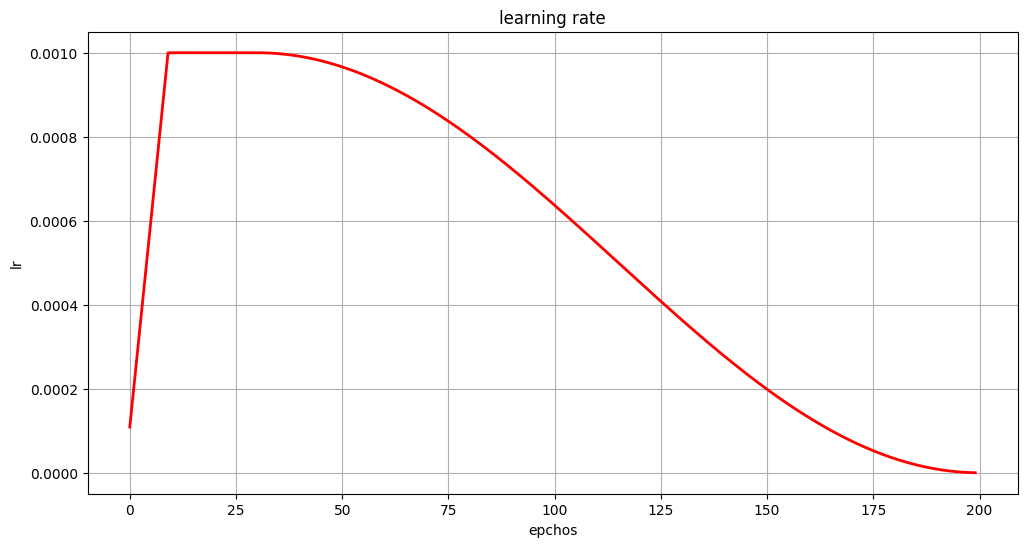

41940
10
20


In [13]:
train_steps_per_epoch = train_tfds_builder.ds_steps_per_epoch
val_steps_per_epoch = val_tfds_builder.ds_steps_per_epoch
from lib.callbacks import CosineDecayScheduler
  
STEPS_PER_EPOCH = train_steps_per_epoch

lr_callback = CosineDecayScheduler(
    learning_rate  = LR,
    alpha = 0.,
    total_epochs = TOTAL_EPOCHS,
    steps_per_epoch = STEPS_PER_EPOCH,
    warmup_steps = STEPS_PER_EPOCH*10, # STEPS_PER_EPOCH*TOTAL_EPOCHS/10
    warmup_steps_update = 10,
    hold_epochs =20,
    base_decay_cycle_epochs = -1,
    t_mul=1.,
    m_mul=1.
) 
lr_callback.test()

lr_callback.warmup_steps_update
print(lr_callback.curr_steps)
print(lr_callback.warmup_epochs)
print(lr_callback.hold_epochs)

In [23]:
lr_callback.warmup_steps_update
print(lr_callback.curr_steps)
print(lr_callback.warmup_epochs)
print(lr_callback.hold_epochs)

41940
10
20


## **<font size="6">` Training`</font>**

In [ ]:
history = model.fit(
    batch_train_dataset, 
    epochs = TOTAL_EPOCHS, 
    steps_per_epoch = train_steps_per_epoch,
    validation_data = batch_val_dataset,
    validation_steps = val_steps_per_epoch
    callbacks = callbacks
)

# **<font size="7">` 3. Evaluation`</font>**

2024-02-05 20:52:36.907299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_23' with dtype float
	 [[{{node Placeholder/_23}}]]
2024-02-05 20:52:36.908214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [33]
	 [[{{node Placeholder/_0}}]]


dict_keys(['image', 'bbox', 'kps', 'image_size', 'bbox_format', 'y_true', 'sample_weight'])
dict_keys(['image', 'bbox', 'kps', 'image_size', 'bbox_format', 'y_true', 'sample_weight'])
dict_keys(['image', 'bbox', 'kps', 'image_size', 'bbox_format', 'y_true', 'sample_weight'])
dict_keys(['image', 'bbox', 'kps', 'image_size', 'bbox_format', 'y_true', 'sample_weight'])
dict_keys(['image', 'bbox', 'kps', 'image_size', 'bbox_format', 'y_true', 'sample_weight'])


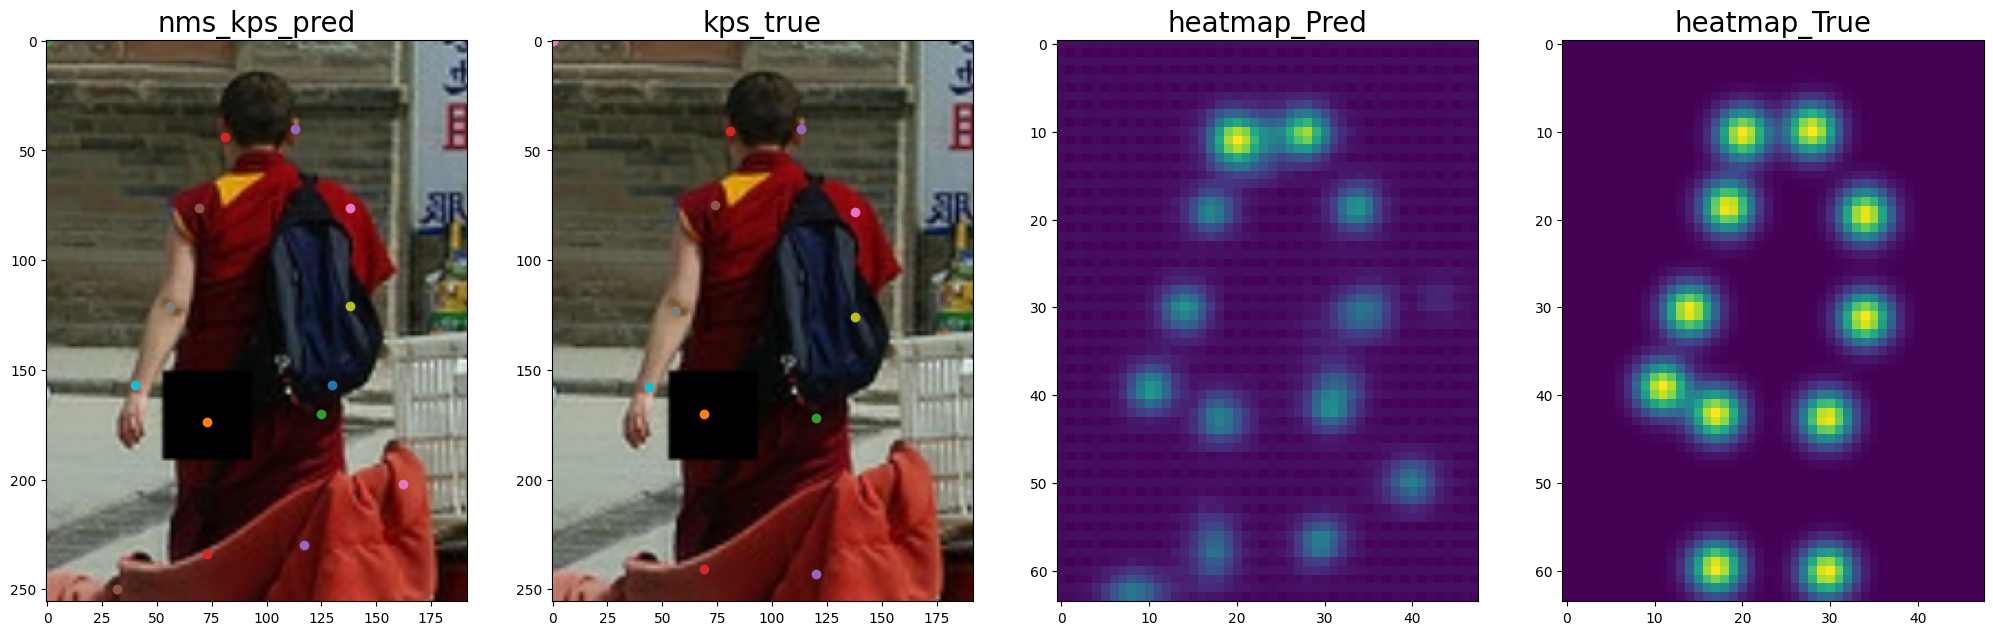

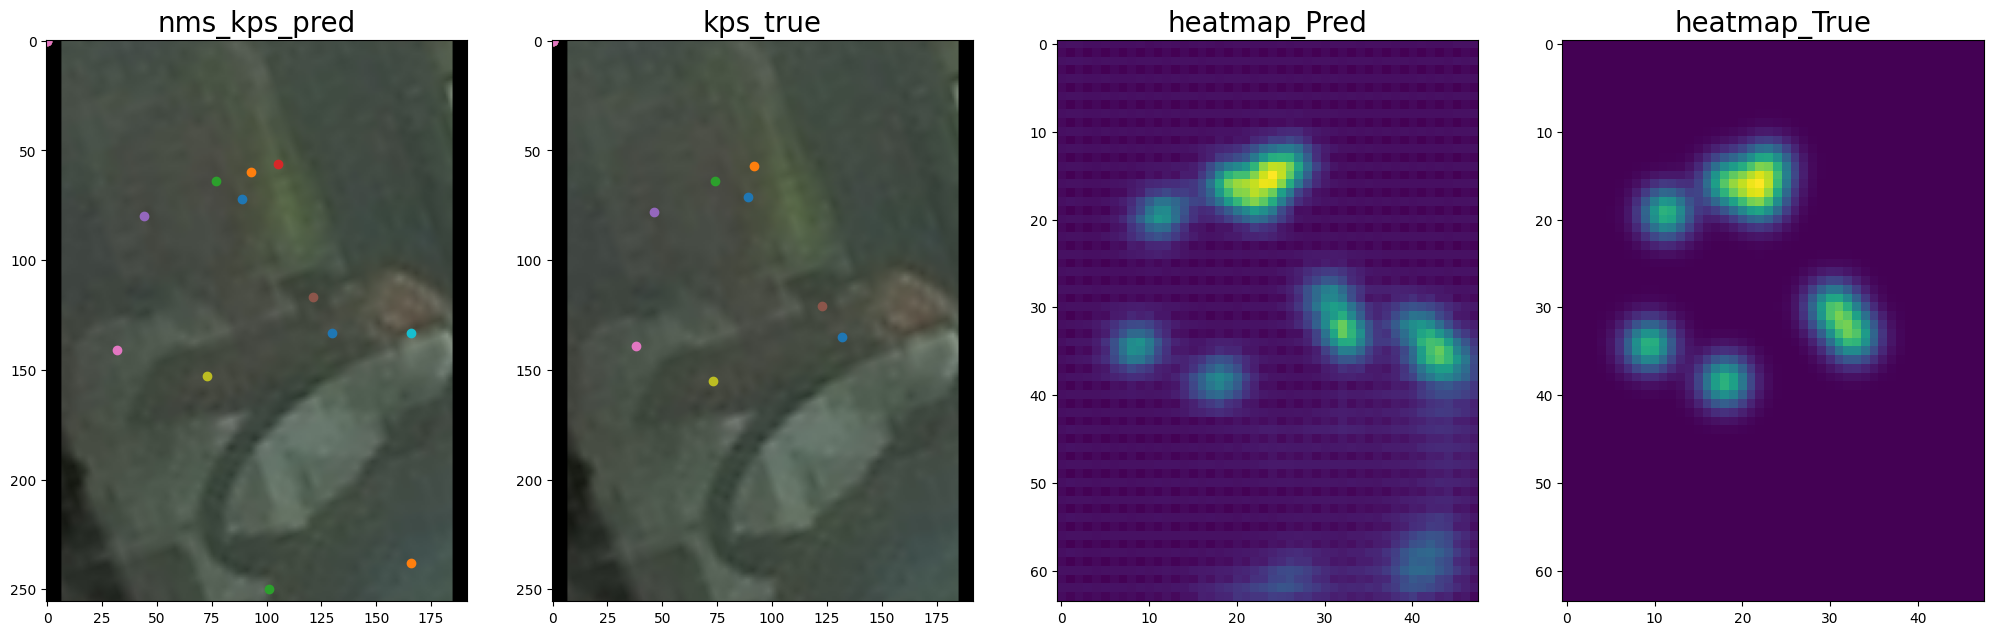

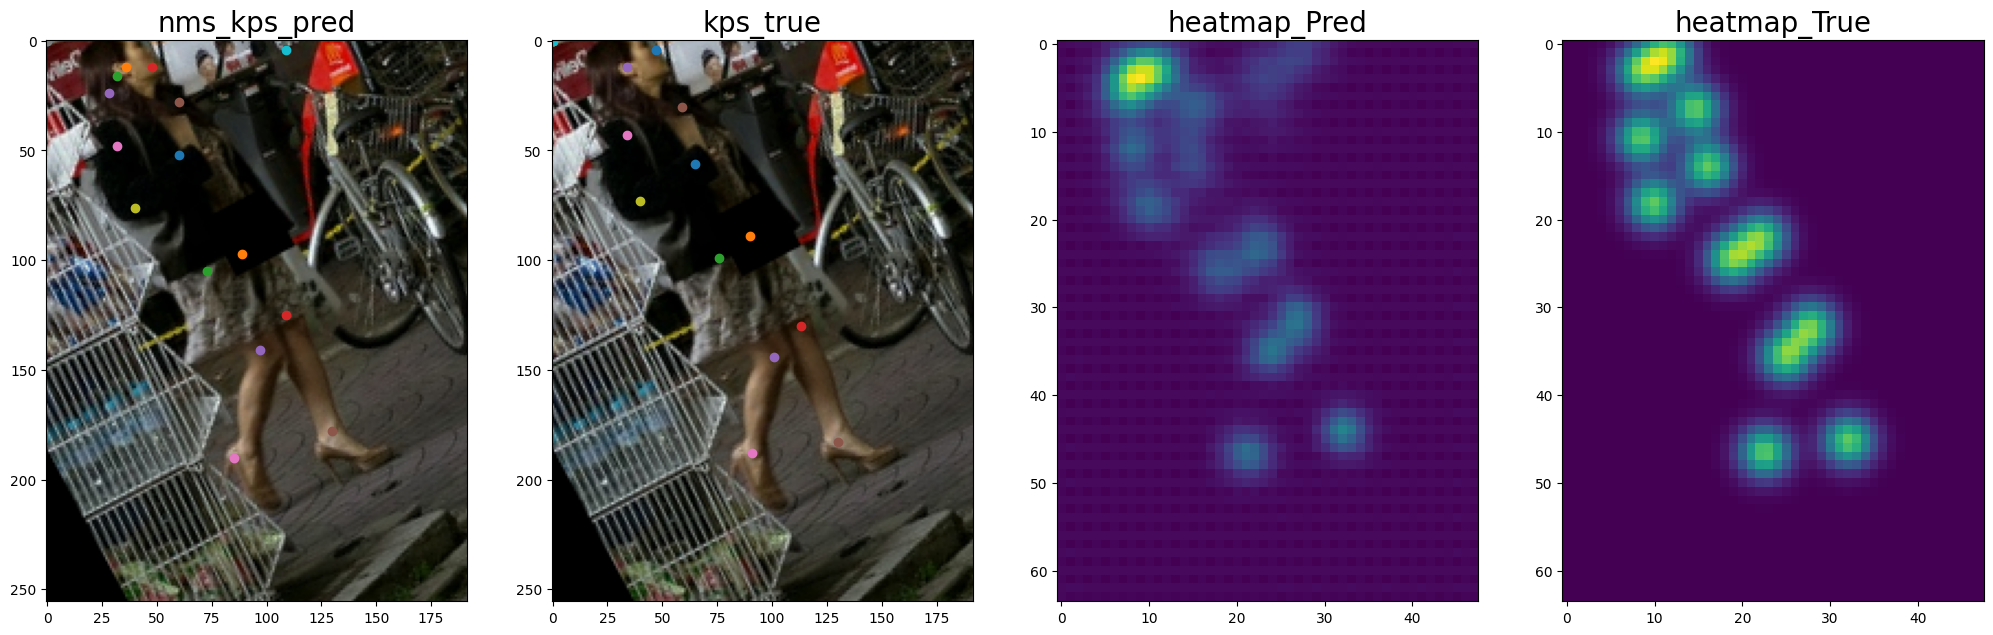

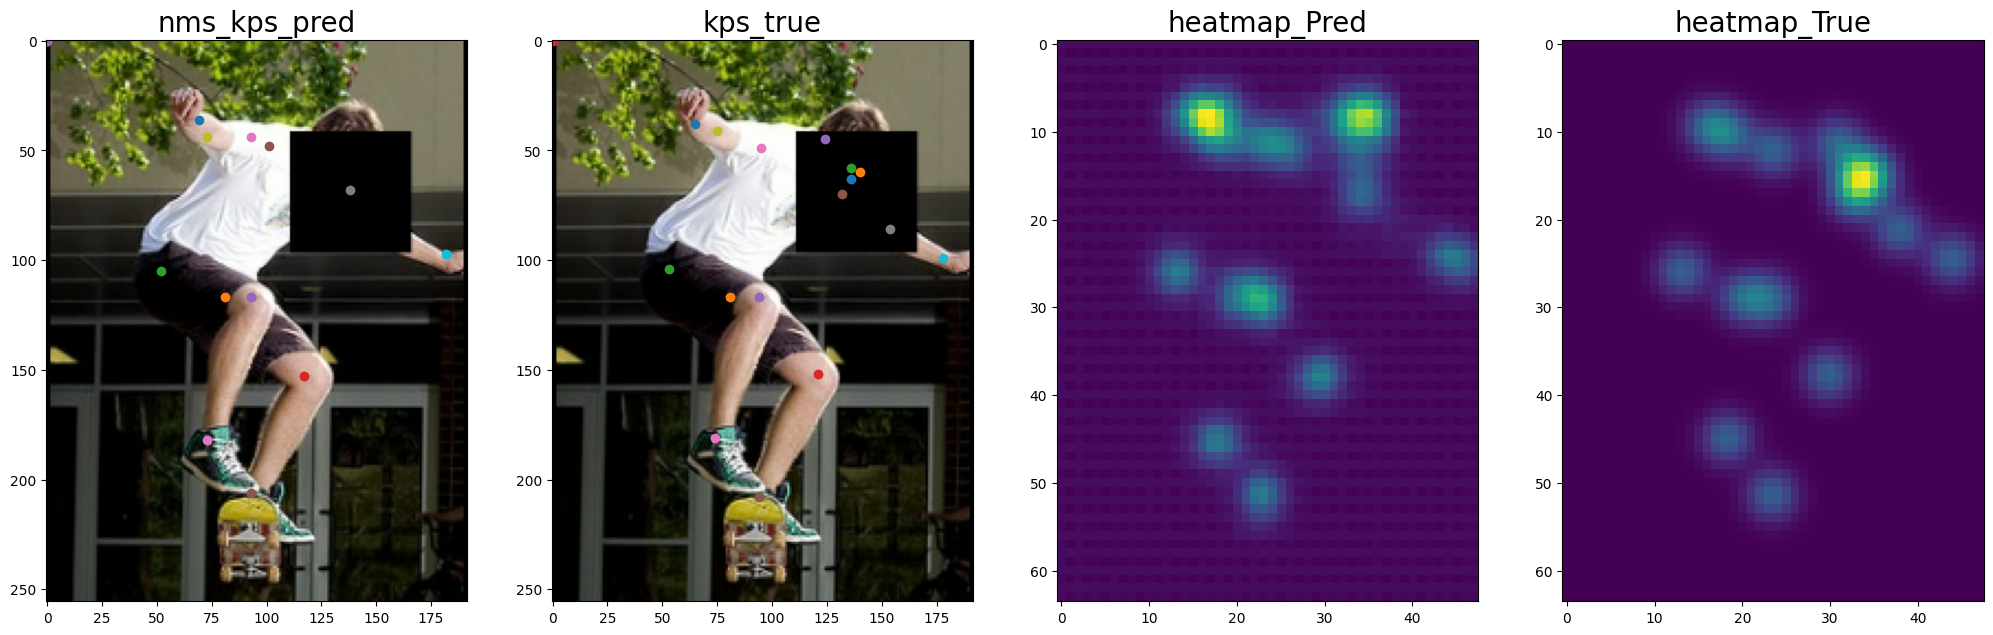

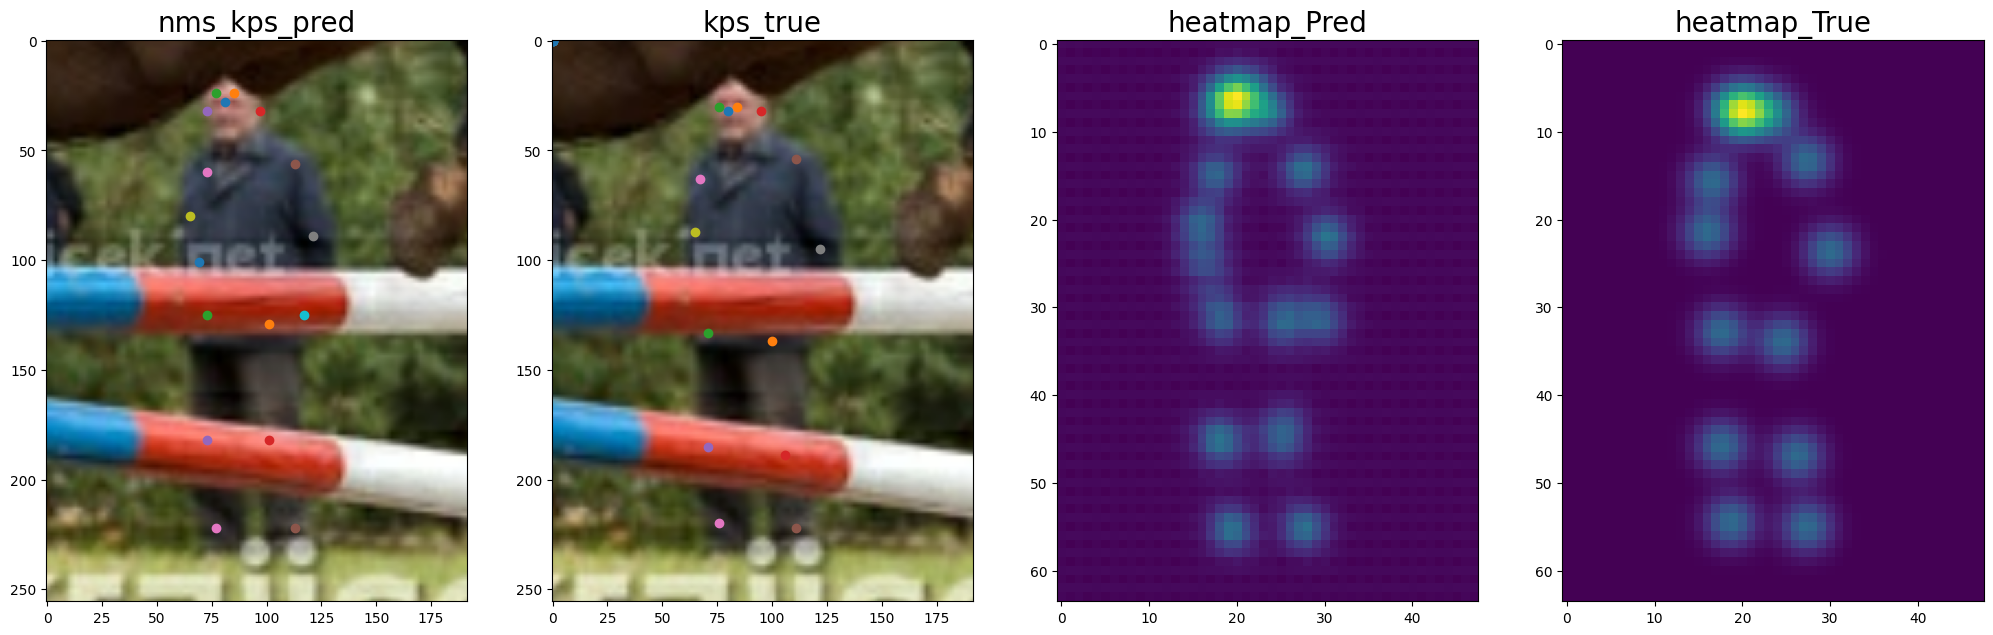

In [11]:
model.codec.hm_thr = tf.concat(
    [tf.ones(shape=(5,), dtype=tf.float32)*0.75, tf.ones(shape=(12,), dtype=tf.float32)*0.35], 
    axis=-1
)

batch_dataset = batch_train_dataset # batch_val_dataset / batch_train_dataset
batch_id = 8
for data in batch_dataset.take(5):
    batch_images = data['image']
    data = model.codec.batch_encode(data)
    print(data.keys())

    kps_trues = data['kps']
    hm_trues = data['y_true']
    hm_preds = model(batch_images)
    kps_preds = model.codec.batch_decode(hm_preds)
    #kps_preds, hm_preds = model.predict(batch_images, with_model_preds=True)

    plt.figure(figsize=(25,10))
    'plot pred kps'
    plt.subplot(1,4,1)
    plt.title('nms_kps_pred',fontsize= 20)
    for i in range(0,17):
        kps_x = int((kps_preds[batch_id,i,0]))
        kps_y = int((kps_preds[batch_id,i,1]))
        plt.scatter(kps_x,kps_y) 
    plt.imshow(batch_images[batch_id,:,:,:])

    plt.subplot(1,4,2)
    plt.title('kps_true',fontsize= 20)
    for i in range(0,17):
        kps_x = int((kps_trues[batch_id,i,0]))
        kps_y = int((kps_trues[batch_id,i,1]))   
        plt.scatter(kps_x,kps_y)  
    plt.imshow(batch_images[batch_id,:,:,:])

    plt.subplot(1,4,3)
    plt.title('heatmap_Pred',fontsize= 20)
    heatmaps_pred = np.array(tf.math.exp(hm_preds[batch_id,:, :, :]))
    plt.imshow(heatmaps_pred.sum(axis=2))

    plt.subplot(1,4,4)
    plt.title('heatmap_True',fontsize= 20)
    heatmaps_true = np.array(hm_trues[batch_id,:, :, :])
    plt.imshow(heatmaps_true.sum(axis=2))